In [1]:
#!/usr/bin/env python3
import os
import sys
import csv
import time
import argparse
import numpy as np
import pandas as pd
import pickle
from random import shuffle

fl_path = os.path.abspath('.')
if fl_path not in sys.path:
    sys.path.append(fl_path)

from ibmfl.util.datasets import load_nursery, load_mnist, load_adult, load_compas, load_german, \
    load_higgs, load_airline, load_diabetes, load_binovf, load_multovf, load_linovf, \
    load_simulated_federated_clustering, load_leaf_femnist, load_cifar10, load_wikipedia

In [128]:
def print_statistics(i, x_test_pi, x_train_pi, nb_labels, y_train_pi):
    print('Party_', i)
    print('nb_x_train: ', np.shape(x_train_pi),
          'nb_x_test: ', np.shape(x_test_pi))
    for l in range(nb_labels):
        print('* Label ', l, ' samples: ', (y_train_pi == l).sum())

In [131]:
def save_mnist_party_data(nb_dp_per_party, spec_per_party, spec_weights, party_folder, dataset_folder):
    """
    Saves MNIST party data

    :param nb_dp_per_party: the number of data points each party should have
    :type nb_dp_per_party: `list[int]`
    :param party_folder: folder to save party data
    :type party_folder: `str`
    :param dataset_folder: folder to save dataset
    :type dataset_folder: `str`
    """

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)
    (x_train, y_train), (x_test, y_test) = load_mnist(download_dir=dataset_folder)
    labels, train_counts = np.unique(y_train, return_counts=True)
    display(labels, train_counts)
    te_labels, test_counts = np.unique(y_test, return_counts=True)
    if not np.all(np.isin(labels, te_labels)):
        print("Warning: test set and train set contain different labels")

    n_specs = len(np.unique(spec_per_party))
    num_train = np.shape(y_train)[0]
    num_test = np.shape(y_test)[0]
    num_labels = np.shape(np.unique(y_test))[0]
    nb_parties = len(nb_dp_per_party)
    party = 0

    for spec in np.unique(spec_per_party):
        spec_weight = spec_weights[spec]
        train_probs = {label: spec_weight[label] for label in labels}
        test_probs = {label: spec_weight[label] for label in te_labels}

        for idx, dp in enumerate(np.array(nb_dp_per_party)[np.array(spec_per_party) == spec]):
            train_p = np.array([train_probs[y_train[idx]]
                                for idx in range(num_train)])
            train_p /= np.sum(train_p)
            train_indices = np.random.choice(num_train, dp, p=train_p)
            test_p = np.array([test_probs[y_test[idx]] for idx in range(num_test)])
            test_p /= np.sum(test_p)

            # Split test evenly
            test_indices = np.random.choice(
                num_test, int(num_test / nb_parties), p=test_p)

            x_train_pi = x_train[train_indices]
            y_train_pi = y_train[train_indices]
            x_test_pi = x_test[test_indices]
            y_test_pi = y_test[test_indices]
            print(x_train_pi.shape)
            # Now put it all in an npz
            name_file = 'data_party' + str(party) + '.npz'
            party += 1
            name_file = os.path.join(party_folder, name_file)
            np.savez(name_file, x_train=x_train_pi, y_train=y_train_pi,
                     x_test=x_test_pi, y_test=y_test_pi)

            print_statistics(idx, x_test_pi, x_train_pi, num_labels, y_train_pi)

            print('Finished! :) Data saved in ', party_folder, name_file)

In [27]:
%matplotlib inline

In [100]:
def plot_sampling(sampling, ax):

    boundaries = np.cumsum(sampling)
    boundaries /= boundaries.max()

    boundaries = np.concatenate([[0], boundaries])
    line = plt.plot([0, 0], [0, 1], c='k')
    line = plt.plot([10, 10], [0, 1], c='k')
    for s0, sf in zip(boundaries[:-1], boundaries[1:]):
        line = ax.plot([s0 * 10, s0 * 10], [0, 1])
        ax.add_patch(plt.Rectangle([s0 * 10, 0], sf * 10 - s0 * 10, 1, color=line[0].get_color()))
        line = ax.plot([s0 * 10, s0 * 10], [0, 1], c='k')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

In [101]:
def get_random_sampling(n, plot=True):
    sizes = np.random.uniform(0.05, 0.95, n)
    sizes /= sizes.sum()

    return sizes

{0: array([0.0242048 , 0.12292157, 0.10856086, 0.12259892, 0.12584891,
        0.14288246, 0.06034752, 0.09593302, 0.04819612, 0.14850583]),
 1: array([0.1198714 , 0.04780915, 0.14036262, 0.14030879, 0.07776786,
        0.16354969, 0.01357347, 0.05303449, 0.08728549, 0.15643704]),
 2: array([0.10862228, 0.01316611, 0.10649088, 0.12417913, 0.17067316,
        0.0886675 , 0.06343273, 0.01426632, 0.18000596, 0.13049594]),
 3: array([0.06850019, 0.16617557, 0.14005915, 0.03921267, 0.08984726,
        0.09101438, 0.0347997 , 0.11573328, 0.15946886, 0.09518893])}

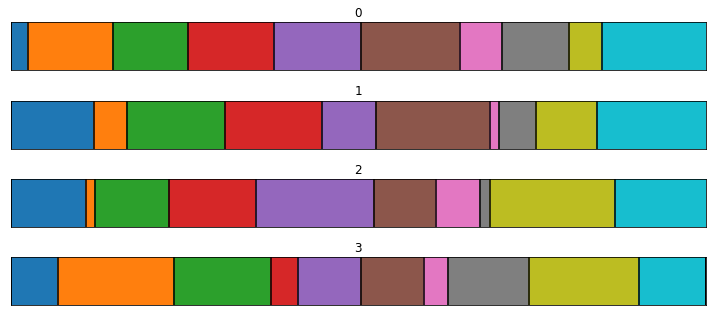

In [119]:
spec_samples = {}

fig, axs = plt.subplots(4, figsize=(10, 4.5))

for i in range(4):
    spec_samples[i] = get_random_sampling(10)
    plot_sampling(spec_samples[i], axs[i])
    axs[i].set_title(str(i))
plt.tight_layout()
spec_samples

In [198]:
pd.DataFrame(spec_samples).mean(axis=1)

0    0.080300
1    0.087518
2    0.123868
3    0.106575
4    0.116034
5    0.121529
6    0.043038
7    0.069742
8    0.118739
9    0.132657
dtype: float64

In [172]:
ss = pd.DataFrame(spec_samples)
for _ in range(10):
    ss = pd.DataFrame(ss.values * (.4 / ss.sum(axis=1)).values.reshape(-1, 1).repeat(4, 1))
    ss = pd.DataFrame(ss.values * (1 / ss.sum(axis=0)).values.reshape(1, -1).repeat(10, 0))
ss.sum(axis=0), ss.sum(axis=1)

(0    1.0
 1    1.0
 2    1.0
 3    1.0
 dtype: float64,
 0    0.4
 1    0.4
 2    0.4
 3    0.4
 4    0.4
 5    0.4
 6    0.4
 7    0.4
 8    0.4
 9    0.4
 dtype: float64)

{0: array([0.02874626, 0.13860664, 0.08469214, 0.11032542, 0.10516584,
        0.11322958, 0.13702664, 0.13500735, 0.03929093, 0.10790922]),
 1: array([0.15526207, 0.05879453, 0.1194239 , 0.13770312, 0.07087537,
        0.14135158, 0.03361294, 0.08139874, 0.07760545, 0.12397229]),
 2: array([0.13476513, 0.01550929, 0.08678826, 0.1167391 , 0.14899415,
        0.07340476, 0.15046579, 0.02097393, 0.1533013 , 0.09905829]),
 3: array([0.08122654, 0.18708953, 0.10909571, 0.03523236, 0.07496464,
        0.07201408, 0.07889463, 0.16261998, 0.12980232, 0.0690602 ])}

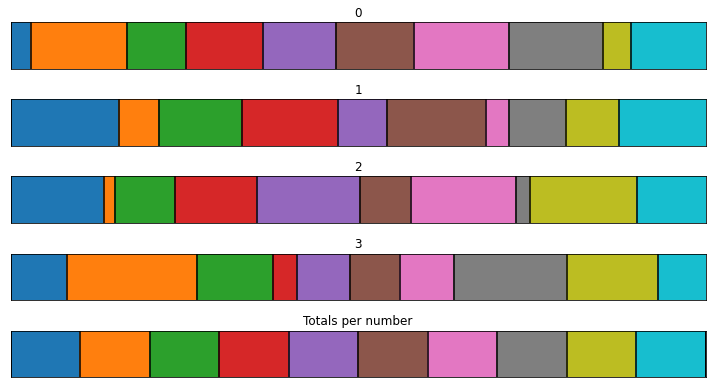

In [181]:
ss_new = {i: col.values for i, col in ss.iteritems()}

fig, axs = plt.subplots(5, figsize=(10, 5.5))

for i in range(4):
    plot_sampling(ss_new[i], axs[i])
    axs[i].set_title(str(i))

plot_sampling(sum(ss_new.values()), axs[4])
axs[4].set_title("Totals per number")

plt.tight_layout()
ss_new

In [2]:
spec_per_party = [0] * 10 + [1] * 40 + [2] * 20 + [3] * 20
[print(i, j) for i, j in enumerate(spec_per_party)]

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [189]:
ss_new_dict = {i: k.tolist() for i, k in ss_new.items()}

import json

with open("../../testtest/unbalanced_data/sums.json", "w") as outfile:
    outfile.write(json.dumps(ss_new_dict, indent=4))

In [190]:
save_mnist_party_data(
    nb_dp_per_party=[200] * 90,
    spec_per_party=[0] * 10 + [1] * 40 + [2] * 20 + [3] * 20,
    spec_weights=ss_new,
    party_folder='../../testtest/unbalanced_data/',
    dataset_folder='../../testtest/unbalanced_data/'
)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

(200, 28, 28)
Party_ 0
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  4
* Label  1  samples:  30
* Label  2  samples:  15
* Label  3  samples:  25
* Label  4  samples:  22
* Label  5  samples:  17
* Label  6  samples:  26
* Label  7  samples:  30
* Label  8  samples:  7
* Label  9  samples:  24
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party0.npz
(200, 28, 28)
Party_ 1
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  7
* Label  1  samples:  28
* Label  2  samples:  16
* Label  3  samples:  24
* Label  4  samples:  19
* Label  5  samples:  22
* Label  6  samples:  27
* Label  7  samples:  25
* Label  8  samples:  5
* Label  9  samples:  27
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party1.npz
(200, 28, 28)
Party_ 2
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  5
* Label  1  samples:  33
* Label  2  s

(200, 28, 28)
Party_ 10
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  29
* Label  1  samples:  22
* Label  2  samples:  26
* Label  3  samples:  28
* Label  4  samples:  14
* Label  5  samples:  25
* Label  6  samples:  5
* Label  7  samples:  22
* Label  8  samples:  11
* Label  9  samples:  18
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party20.npz
(200, 28, 28)
Party_ 11
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  35
* Label  1  samples:  13
* Label  2  samples:  23
* Label  3  samples:  28
* Label  4  samples:  13
* Label  5  samples:  31
* Label  6  samples:  2
* Label  7  samples:  13
* Label  8  samples:  10
* Label  9  samples:  32
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party21.npz
(200, 28, 28)
Party_ 12
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  26
* Label  1  samples:  14
* Lab

Party_ 30
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  38
* Label  1  samples:  17
* Label  2  samples:  22
* Label  3  samples:  26
* Label  4  samples:  12
* Label  5  samples:  25
* Label  6  samples:  7
* Label  7  samples:  20
* Label  8  samples:  13
* Label  9  samples:  20
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party40.npz
(200, 28, 28)
Party_ 31
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  23
* Label  1  samples:  8
* Label  2  samples:  26
* Label  3  samples:  39
* Label  4  samples:  15
* Label  5  samples:  25
* Label  6  samples:  8
* Label  7  samples:  14
* Label  8  samples:  16
* Label  9  samples:  26
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party41.npz
(200, 28, 28)
Party_ 32
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  35
* Label  1  samples:  12
* Label  2  samples:

nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  30
* Label  1  samples:  5
* Label  2  samples:  14
* Label  3  samples:  25
* Label  4  samples:  31
* Label  5  samples:  10
* Label  6  samples:  30
* Label  7  samples:  4
* Label  8  samples:  33
* Label  9  samples:  18
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party60.npz
(200, 28, 28)
Party_ 11
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  36
* Label  1  samples:  1
* Label  2  samples:  23
* Label  3  samples:  32
* Label  4  samples:  28
* Label  5  samples:  12
* Label  6  samples:  23
* Label  7  samples:  1
* Label  8  samples:  25
* Label  9  samples:  19
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party61.npz
(200, 28, 28)
Party_ 12
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  26
* Label  1  samples:  4
* Label  2  samples:  22
* Label

(200, 28, 28)
Party_ 10
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  14
* Label  1  samples:  61
* Label  2  samples:  18
* Label  3  samples:  6
* Label  4  samples:  12
* Label  5  samples:  11
* Label  6  samples:  21
* Label  7  samples:  22
* Label  8  samples:  25
* Label  9  samples:  10
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party80.npz
(200, 28, 28)
Party_ 11
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  8
* Label  1  samples:  43
* Label  2  samples:  19
* Label  3  samples:  12
* Label  4  samples:  10
* Label  5  samples:  13
* Label  6  samples:  19
* Label  7  samples:  32
* Label  8  samples:  23
* Label  9  samples:  21
Finished! :) Data saved in  ../../testtest/unbalanced_data/ ../../testtest/unbalanced_data/data_party81.npz
(200, 28, 28)
Party_ 12
nb_x_train:  (200, 28, 28) nb_x_test:  (111, 28, 28)
* Label  0  samples:  7
* Label  1  samples:  38
* Labe

# Generate runner yaml

In [3]:
yml = {
    "experiments": [{
        "agg_machine": "local0",
        "local_ibmfl_dir": "/home/trevormaxjs/Documents/Engineering/Research/ibmfl",
        "local_staging_dir": "/home/trevormaxjs/Documents/Engineering/Research",
        "n_parties": len(spec_per_party),
        "n_rounds": 20,
        "n_trials": 1,
        "party_machines": [],
        "postproc_fn": "gen_reward_vs_time_plots",
        "postproc_x_key": "post_train:ts",
        "postproc_y_keys": [
            "post_train:eval:loss",
            "post_train:eval:acc"
        ],
        "shuffle_party_machines": False,
        "isLocalRun": False
    }],
    "isLocalRun": False,
    "machines": {
        "default": {
            "ibmfl_dir": "/home/trevormaxjs/Documents/Engineering/Research/ibmfl",
            "staging_dir": "/home/trevormaxjs/Documents/Engineering/Research",
            "venv_dir": "/home/trevormaxjs/Documents/Engineering/Research/venv",
            "venv_uses_conda": False
        }
    }
}
yml

{'experiments': [{'agg_machine': 'local0',
   'local_ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl',
   'local_staging_dir': '/home/trevormaxjs/Documents/Engineering/Research',
   'n_parties': 90,
   'n_rounds': 20,
   'n_trials': 1,
   'party_machines': [],
   'postproc_fn': 'gen_reward_vs_time_plots',
   'postproc_x_key': 'post_train:ts',
   'postproc_y_keys': ['post_train:eval:loss', 'post_train:eval:acc'],
   'shuffle_party_machines': False,
   'isLocalRun': False}],
 'isLocalRun': False,
 'machines': {'default': {'ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl',
   'staging_dir': '/home/trevormaxjs/Documents/Engineering/Research',
   'venv_dir': '/home/trevormaxjs/Documents/Engineering/Research/venv',
   'venv_uses_conda': False}}}

In [4]:
spec_per_dict = {i: j for i, j in zip(*np.unique(spec_per_party, return_counts=True))}
spec_per_dict

{0: 10, 1: 40, 2: 20, 3: 20}

In [5]:
machines = {
    0: {
        "name": "popdesk",
        "ip_address": "192.168.1.154",
        "ssh_username": "trevormaxjs",
        "staging_dir": "/home/trevormaxjs/ibmfl",
        "venv_dir": "/home/trevormaxjs/ibmfl/venv",
        "ibmfl_dir": "/home/trevormaxjs/ibmfl/ibmfl",
        "n_parties": spec_per_dict[0]
    },
    1: {
        "name": "worktop",
        "ip_address": "192.168.1.167",
        "ssh_username": "trevormaxjs",
        "n_parties": spec_per_dict[1]
    },
    2: {
        "name": "schooltop",
        "ip_address": "192.168.1.176",
        "ssh_username": "trevormaxjs",
        "n_parties": spec_per_dict[2]
    },
    3: {
        "name": "keegdesk",
        "ip_address": "192.168.1.197",
        "ssh_username": "mud",
        "staging_dir": "/home/mud/ibmfl",
        "venv_dir": "/home/mud/ibmfl/venv",
        "ibmfl_dir": "/home/mud/ibmfl/ibmfl",
        "n_parties": spec_per_dict[3]
    },
}

In [6]:
machines

{0: {'name': 'popdesk',
  'ip_address': '192.168.1.154',
  'ssh_username': 'trevormaxjs',
  'staging_dir': '/home/trevormaxjs/ibmfl',
  'venv_dir': '/home/trevormaxjs/ibmfl/venv',
  'ibmfl_dir': '/home/trevormaxjs/ibmfl/ibmfl',
  'n_parties': 10},
 1: {'name': 'worktop',
  'ip_address': '192.168.1.167',
  'ssh_username': 'trevormaxjs',
  'n_parties': 40},
 2: {'name': 'schooltop',
  'ip_address': '192.168.1.176',
  'ssh_username': 'trevormaxjs',
  'n_parties': 20},
 3: {'name': 'keegdesk',
  'ip_address': '192.168.1.197',
  'ssh_username': 'mud',
  'staging_dir': '/home/mud/ibmfl',
  'venv_dir': '/home/mud/ibmfl/venv',
  'ibmfl_dir': '/home/mud/ibmfl/ibmfl',
  'n_parties': 20}}

In [7]:
i = 0
port_number = 8000

for machine, param in machines.items():
    name = param.pop("name")
    n_parties = param.pop("n_parties")
    for _ in range(n_parties):
        yml["machines"][f"{name}{i}"] = param.copy()
        yml["machines"][f"{name}{i}"]["port_number"] = port_number
        yml["experiments"][0]["party_machines"].append(f"{name}{i}")
        i += 1
        port_number += 1

yml

{'experiments': [{'agg_machine': 'local0',
   'local_ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl',
   'local_staging_dir': '/home/trevormaxjs/Documents/Engineering/Research',
   'n_parties': 90,
   'n_rounds': 20,
   'n_trials': 1,
   'party_machines': ['popdesk0',
    'popdesk1',
    'popdesk2',
    'popdesk3',
    'popdesk4',
    'popdesk5',
    'popdesk6',
    'popdesk7',
    'popdesk8',
    'popdesk9',
    'worktop10',
    'worktop11',
    'worktop12',
    'worktop13',
    'worktop14',
    'worktop15',
    'worktop16',
    'worktop17',
    'worktop18',
    'worktop19',
    'worktop20',
    'worktop21',
    'worktop22',
    'worktop23',
    'worktop24',
    'worktop25',
    'worktop26',
    'worktop27',
    'worktop28',
    'worktop29',
    'worktop30',
    'worktop31',
    'worktop32',
    'worktop33',
    'worktop34',
    'worktop35',
    'worktop36',
    'worktop37',
    'worktop38',
    'worktop39',
    'worktop40',
    'worktop41',
    'worktop42',
    '

In [8]:
yml["machines"]["local0"] = machines[2]
yml["machines"]["local0"]["port_number"] = 5000

In [9]:
yml

{'experiments': [{'agg_machine': 'local0',
   'local_ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl',
   'local_staging_dir': '/home/trevormaxjs/Documents/Engineering/Research',
   'n_parties': 90,
   'n_rounds': 20,
   'n_trials': 1,
   'party_machines': ['popdesk0',
    'popdesk1',
    'popdesk2',
    'popdesk3',
    'popdesk4',
    'popdesk5',
    'popdesk6',
    'popdesk7',
    'popdesk8',
    'popdesk9',
    'worktop10',
    'worktop11',
    'worktop12',
    'worktop13',
    'worktop14',
    'worktop15',
    'worktop16',
    'worktop17',
    'worktop18',
    'worktop19',
    'worktop20',
    'worktop21',
    'worktop22',
    'worktop23',
    'worktop24',
    'worktop25',
    'worktop26',
    'worktop27',
    'worktop28',
    'worktop29',
    'worktop30',
    'worktop31',
    'worktop32',
    'worktop33',
    'worktop34',
    'worktop35',
    'worktop36',
    'worktop37',
    'worktop38',
    'worktop39',
    'worktop40',
    'worktop41',
    'worktop42',
    '

In [10]:
import yaml

with open("../../testtest/unbalanced_data/config_runner.yml", 'w') as file:
    documents = yaml.dump(yml, file)
